In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from k2 import K2Processor
from evaluation import extract_params, spawn_model

In [3]:
import utils
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import networkx as nx
import os

In [4]:
test_df = pd.read_csv('../data/results/all_test_results_points.csv', index_col=0)

In [5]:
filt = test_df[(test_df.encoder == 'COLLAPSE') & (test_df.method == 'Prospector') & (test_df.metric == 'ap')].sort_values('value', ascending=False)
filt.head()

,encoder,model,threshold,datum_id,regime,metric,value,method
502,COLLAPSE,k25_r4_cutoff8.00_alpha1.0000_tau4.00_lamnan.m...,0.95,4h3sA.pkl,all,ap,1.0,Prospector
416,COLLAPSE,k25_r4_cutoff8.00_alpha1.0000_tau4.00_lamnan.m...,0.95,5ud5A.pkl,all,ap,1.0,Prospector
246,COLLAPSE,k25_r4_cutoff8.00_alpha1.0000_tau4.00_lamnan.m...,0.95,1kk1A.pkl,all,ap,1.0,Prospector
276,COLLAPSE,k25_r4_cutoff8.00_alpha1.0000_tau4.00_lamnan.m...,0.95,5tt5A.pkl,all,ap,1.0,Prospector
282,COLLAPSE,k25_r4_cutoff8.00_alpha1.0000_tau4.00_lamnan.m...,0.95,3vovA.pkl,all,ap,1.0,Prospector


<Axes: >

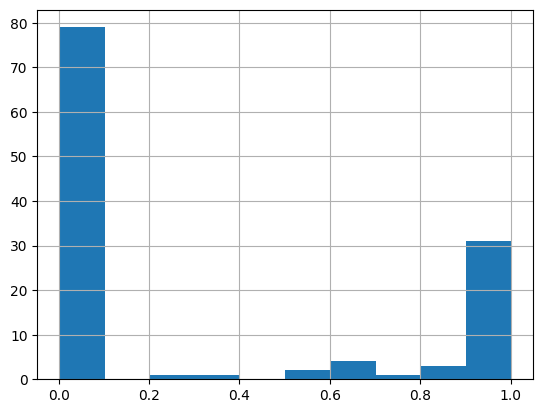

In [6]:
filt.value.hist()

In [7]:
high_precision = filt[filt.value > 0.5]

In [8]:
metal = 'ZN'
encoder = 'COLLAPSE'
model_str = 'k25_r4_cutoff8.00_alpha1.0000_tau4.00_lamnan.model'
k,r,cutoff,alpha,tau,lam = extract_params(model_str)

processor_cache_dir = f"../data/{encoder}_{metal}_gridsearch_results/{encoder}-fitted_k2_processors"
model_cache_dir = f"../data/{encoder}_{metal}_gridsearch_results/{encoder}-fitted_k2_models"
# G_test_dir = f"../data/{encoder}_{metal}_cutoff_test_graphs_2"
# G_train_dir = f"../data/{encoder}_{metal}_cutoff_train_graphs_2"
G_dir = f"../data/{encoder}_{metal}_{cutoff}_test_graphs_2"

k,r,cutoff,alpha,tau,lam = extract_params(model_str)
processor_name = "k%d_cutoff%.2f.processor" % (k, cutoff)

In [ ]:
from tqdm import tqdm
def linearized_kernel(G_id, model_str, processor_cache_dir, model_cache_dir, G_dir, datatype="protein"):
    k,r,cutoff,alpha,tau,lam = extract_params(model_str)
    processor_name = "k%d_cutoff%.2f.processor" % (k, cutoff)
    G_dir = G_dir.replace('cutoff', '%.1f'%cutoff)

    proc = utils.deserialize_model(os.path.join(processor_cache_dir, processor_name))
    model = utils.deserialize_model(os.path.join(model_cache_dir, model_str))

    G_path = G_dir + "/" + G_id + ".pkl"
    G = utils.deserialize(G_path)
    sprite = utils.construct_sprite(G, proc)
    P = model.prospect(G)

    kernel_map = model.motif_graph_weight(sprite)
    n_weights = list(nx.get_node_attributes(kernel_map, 'n_weight').values())
    e_weights = list(nx.get_edge_attributes(kernel_map, 'e_weight').values())
    lin_kernel = n_weights + e_weights

    return lin_kernel

In [ ]:
kernel_arr = []
labels = []
for g_path in tqdm(filt[filt.value ==1].datum_id):
    G_id = g_path.strip('.pkl')
    kernel = linearized_kernel(G_id, model_str, processor_cache_dir, model_cache_dir, G_dir, datatype="protein")
    kernel_arr.append(kernel)
    labels.append(G_id)
kernel_arr = np.array(kernel_arr)

In [ ]:
import seaborn as sns
def setup_figure(width=6, height=3):
    fig, ax = plt.subplots(figsize=(width,height))
    sns.set(style='white')
    sns.set_context('paper')
    return fig, ax
pal = sns.color_palette('tab20')

In [ ]:
sns.clustermap(pd.DataFrame(kernel_arr, index=filt[filt.value ==1].datum_id), col_cluster=False)

In [ ]:
cmap = {2: 'gray', 3: 'orange', 4: 'red'}
ex_class = {'3vhtB': 3,
 '1kk1A': 4,
 '5tt5A': 4,
 '5ploA': 3,
 '4v2wB': 3,
 '5ud5A': 3,
 '2l30A': 3,
 '5exhC': 4,
 '2kkfA': 4,
 '3q1dA': 3,
 '2yuuA': 3,
 '2lulA': 3,
 '2orwA': 4,
 '1p91B': 3,
 '1xjsA': 3,
 '4r8pN': 4,
 '2ap1A': 3,
 '3vovA': 3,
 '4m3pA': 3,
 '5n6fA': 3,
 '4h3sA': 3,
 '4m0wA': 4,
 '4rvnB': 3,
 '2bx2L': 4}

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

fig, ax = setup_figure(7,3)
linkage_data = linkage(kernel_arr, method='average', metric='euclidean')
dendrogram(linkage_data, labels=labels)
plt.title('Linearized kernel clustering results')
plt.xticks(rotation=90, ha='center')
[t.set_color(i) for (i,t) in
 zip([cmap[ex_class.get(x.get_text(), 2)] for x in ax.xaxis.get_ticklabels()], ax.xaxis.get_ticklabels())]
plt.tight_layout()
plt.savefig("../data/figures/zn_clusters.png", dpi=300, format='png')
plt.show()

/Users/AWFDerry/anaconda3/envs/k2/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator KMeans from version 1.3.1 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


No G provided, showing model-wide kernel hash-graph
Displaying motif graph with log2 scaling
[array([0.12156863, 0.46666667, 0.70588235, 1.        ]), array([0.68235294, 0.78039216, 0.90980392, 1.        ]), array([1.        , 0.49803922, 0.05490196, 1.        ]), array([1.        , 0.73333333, 0.47058824, 1.        ]), array([0.17254902, 0.62745098, 0.17254902, 1.        ]), array([0.59607843, 0.8745098 , 0.54117647, 1.        ]), array([0.83921569, 0.15294118, 0.15686275, 1.        ]), array([1.        , 0.59607843, 0.58823529, 1.        ]), array([0.58039216, 0.40392157, 0.74117647, 1.        ]), array([0.77254902, 0.69019608, 0.83529412, 1.        ]), array([0.54901961, 0.3372549 , 0.29411765, 1.        ]), array([0.76862745, 0.61176471, 0.58039216, 1.        ]), array([0.89019608, 0.46666667, 0.76078431, 1.        ]), array([0.96862745, 0.71372549, 0.82352941, 1.        ]), array([0.49803922, 0.49803922, 0.49803922, 1.        ]), array([0.78039216, 0.78039216, 0.78039216, 1.      

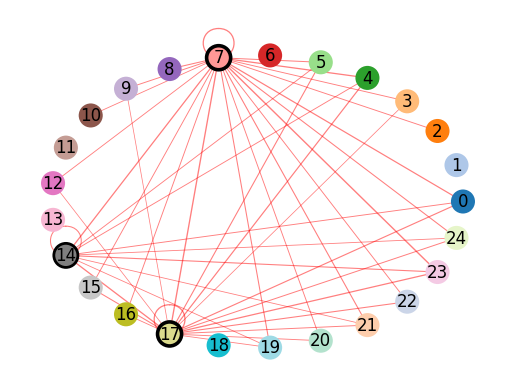

In [9]:
model = utils.deserialize_model(os.path.join(model_cache_dir, model_str))
model.visualize_motif_graph(labels=True)

No G provided, showing model-wide kernel hash-graph
Displaying motif graph with log2 scaling


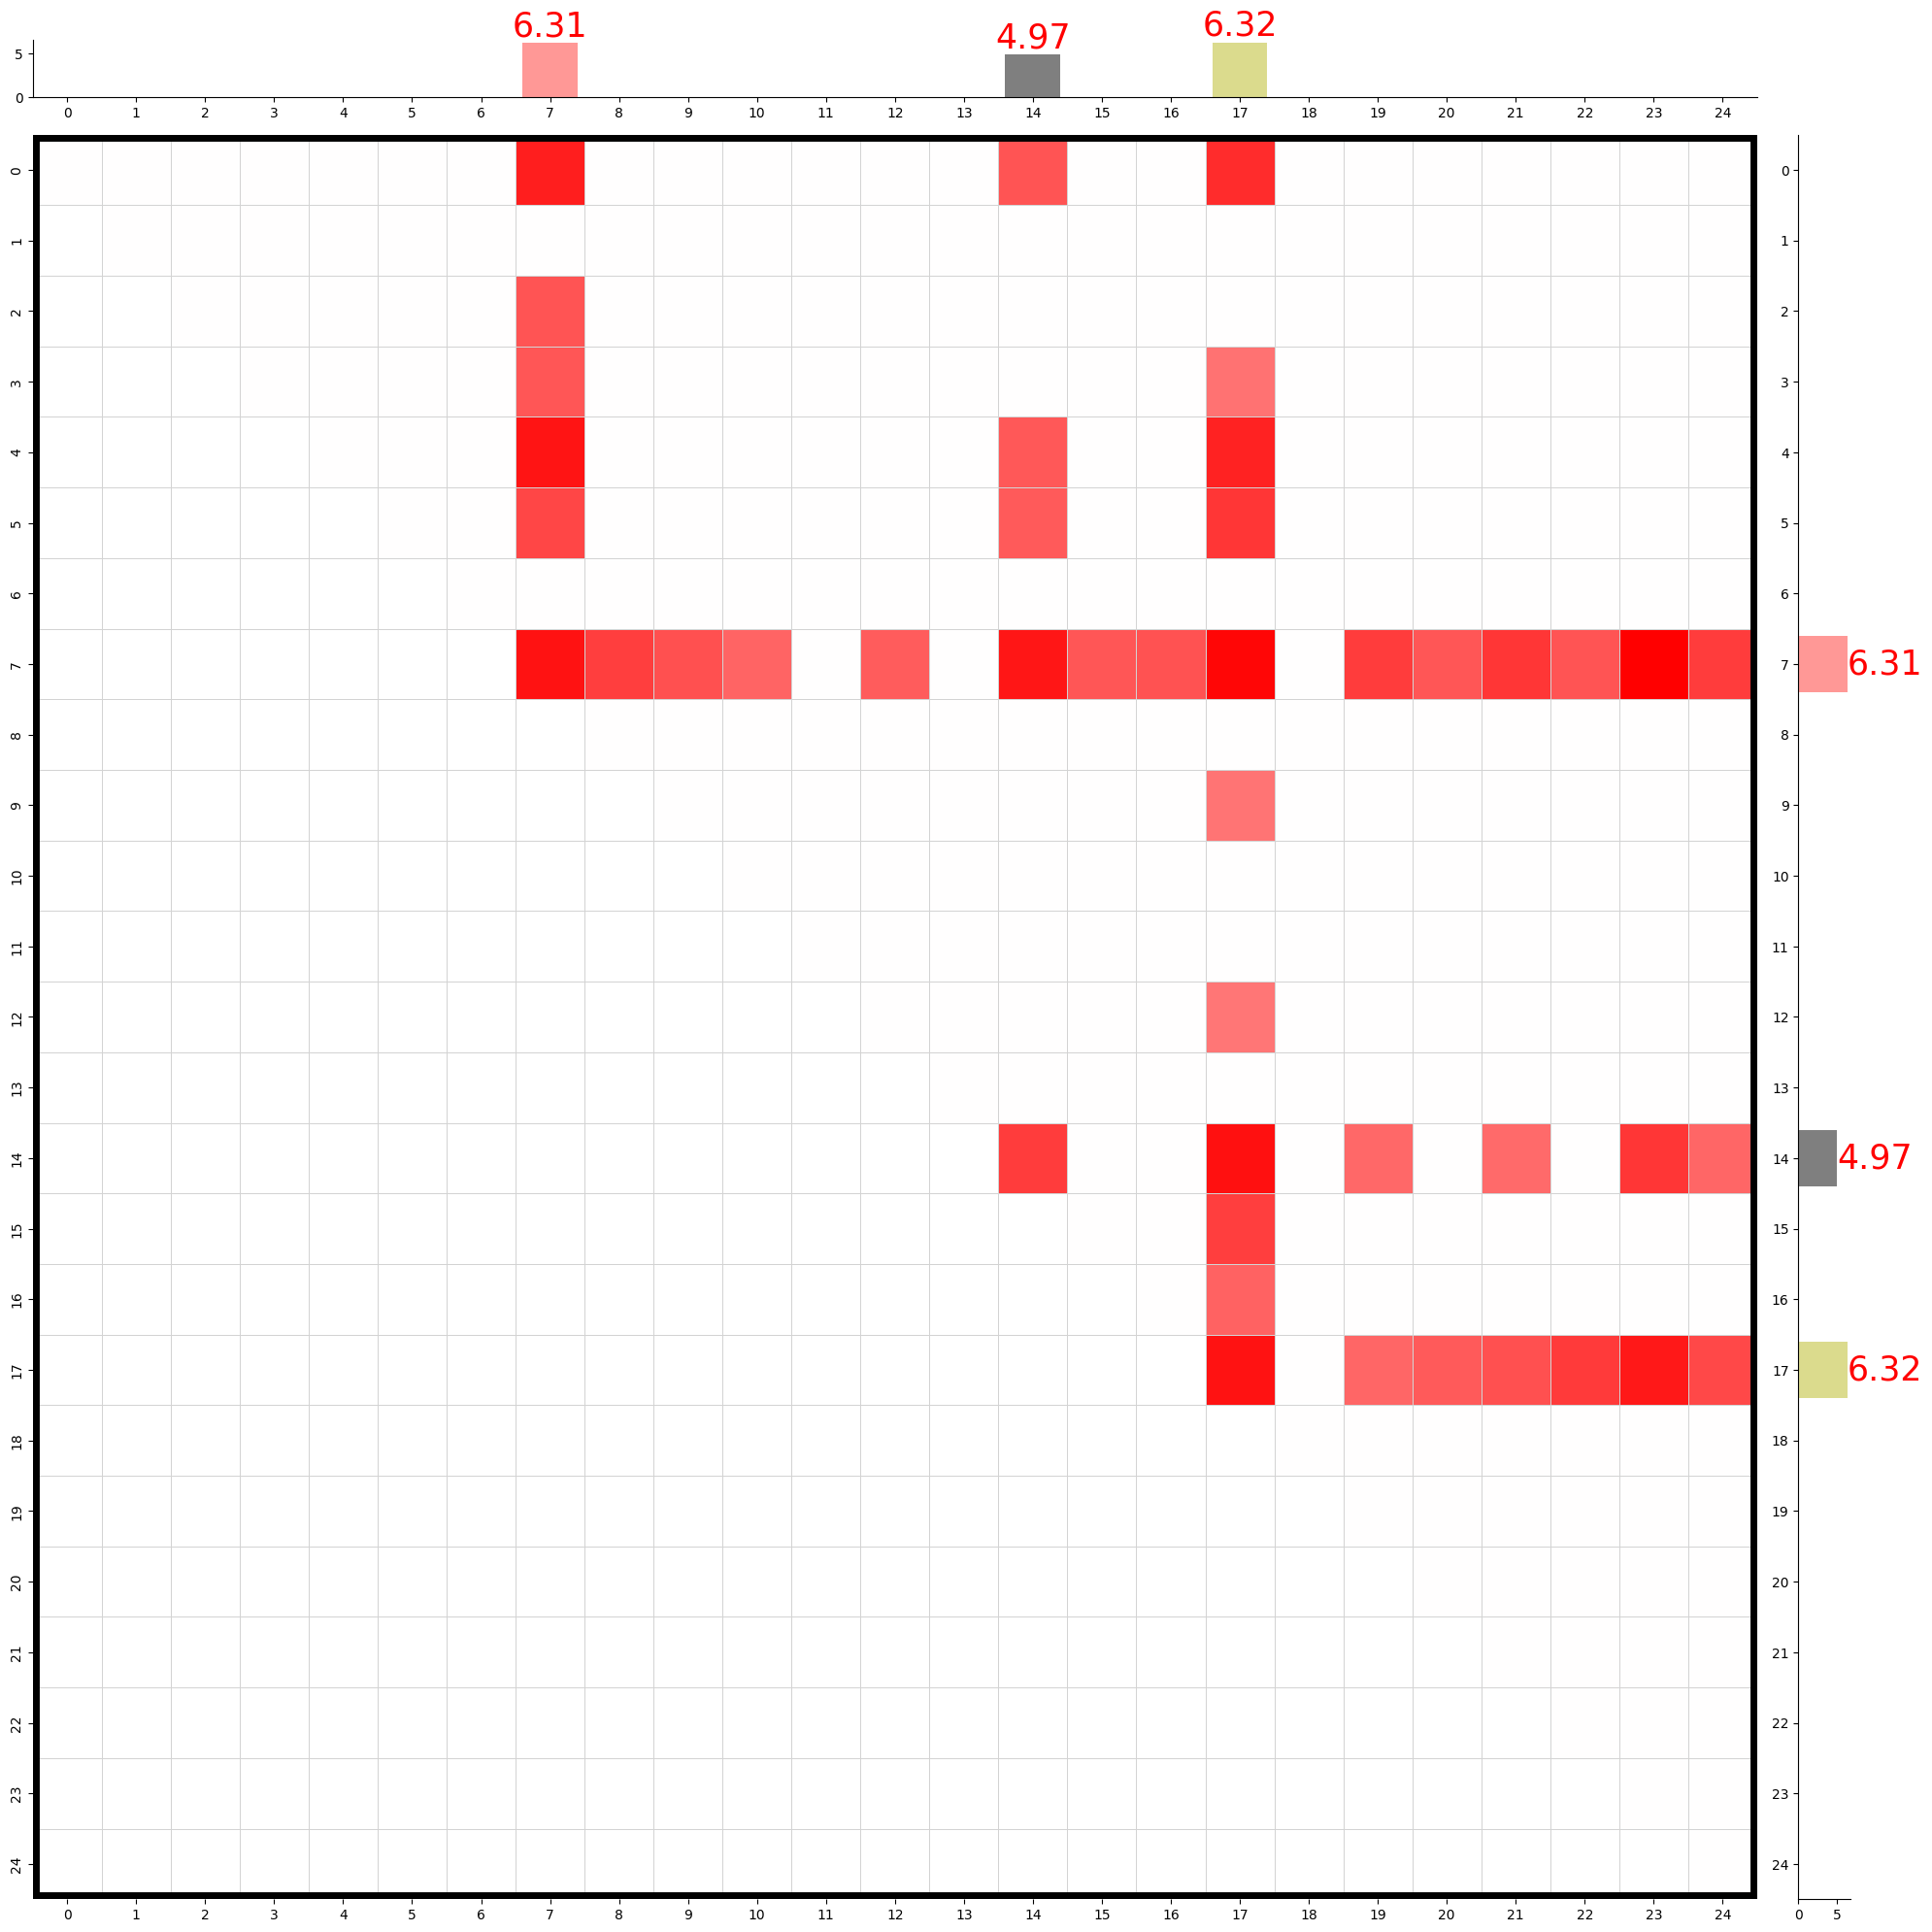

In [10]:
model.visualize_motif_graph(style="matrix", labels=True)

In [38]:
def create_visualizations(G_id, model_str, processor_cache_dir, model_cache_dir, G_dir, datatype="protein", gt_path=None):
    if datatype == "protein":
        k,r,cutoff,alpha,tau,lam = extract_params(model_str)
        processor_name = "k%d_cutoff%.2f.processor" % (k, cutoff)
        G_dir = G_dir.replace('cutoff', '%.1f'%cutoff)
    elif datatype in ['text', "image"]:
        k,r,alpha,tau,lam = extract_params(model_str)
        processor_name = "k%d.processor" % (k)

    proc = utils.deserialize_model(os.path.join(processor_cache_dir, processor_name))
    model = utils.deserialize_model(os.path.join(model_cache_dir, model_str))
    model.processor = proc
    model.visualize_motif_graph(labels=True) # sets color
    color_assign = model.color_assignments

    if datatype == "protein":
        G_path = G_dir + "/" + G_id + ".pkl"
    elif datatype in ["text","image"]:
        G_path = G_dir + "/" + G_id 
    G = utils.deserialize(G_path)
    sprite = utils.construct_sprite(G, proc)
    P = model.prospect(G)
    print('visualizing motif graph...')
    kernel_map = model.visualize_motif_graph(G)
    kernel_map = model.visualize_motif_graph(G,style="graph",labels=True)
    kernel_map2 = model.visualize_motif_graph(G,style="matrix",labels=True)
    
    if datatype=='protein':
        print('visualizing sprite...')
        sprite_viz = utils.visualize_protein_sprite(sprite, colors=color_assign)
        print('visualizing prospect map...')
        prospect_map = utils.visualize_protein_sprite(P, prospect_flag=True)
        print('visualizing ground truth...')
        gt = utils.visualize_protein_sprite(utils.set_graph_emb(G, 'gt'), gt_flag=True)
    elif datatype in ['text', "image"]:
        sprite_map = utils.convert_graph2arr(sprite)
        sprite_viz = utils.visualize_quantizedZ(sprite_map, colors=color_assign)
        sprite_graph = utils.visualize_sprite(sprite, color_assign=color_assign)
        prospect_map = model.visualize_prospect_map(P)
        if datatype == "image":
            gt = utils.deserialize(os.path.join(gt_path, G_id + "-graph"))
        elif datatype == "text":
            G_id = G_id.split("_graph")[0] + "_gt.obj"
            gt = utils.deserialize(os.path.join(gt_path, G_id))
        gt_arr = utils.convert_GTgraph2arr(gt)
        utils.visualize_GTmap(gt_arr, sprite_map)

    return kernel_map, sprite_viz, prospect_map, gt

/Users/AWFDerry/anaconda3/envs/k2/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator KMeans from version 1.3.1 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


No G provided, showing model-wide kernel hash-graph
Displaying motif graph with log2 scaling
[array([0.12156863, 0.46666667, 0.70588235, 1.        ]), array([0.68235294, 0.78039216, 0.90980392, 1.        ]), array([1.        , 0.49803922, 0.05490196, 1.        ]), array([1.        , 0.73333333, 0.47058824, 1.        ]), array([0.17254902, 0.62745098, 0.17254902, 1.        ]), array([0.59607843, 0.8745098 , 0.54117647, 1.        ]), array([0.83921569, 0.15294118, 0.15686275, 1.        ]), array([1.        , 0.59607843, 0.58823529, 1.        ]), array([0.58039216, 0.40392157, 0.74117647, 1.        ]), array([0.77254902, 0.69019608, 0.83529412, 1.        ]), array([0.54901961, 0.3372549 , 0.29411765, 1.        ]), array([0.76862745, 0.61176471, 0.58039216, 1.        ]), array([0.89019608, 0.46666667, 0.76078431, 1.        ]), array([0.96862745, 0.71372549, 0.82352941, 1.        ]), array([0.49803922, 0.49803922, 0.49803922, 1.        ]), array([0.78039216, 0.78039216, 0.78039216, 1.      

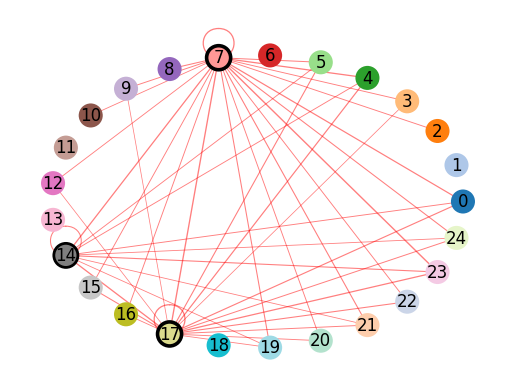

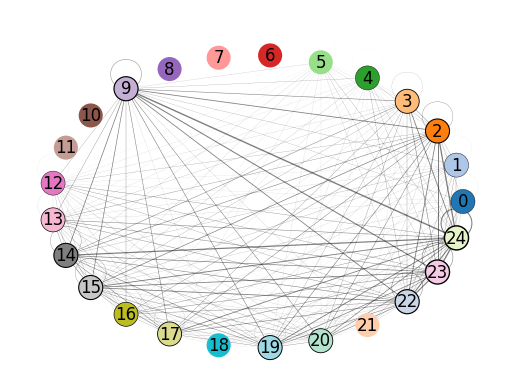

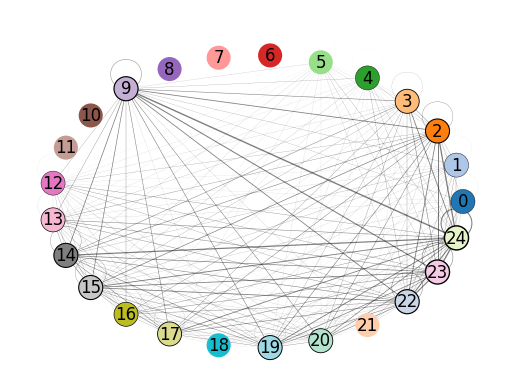

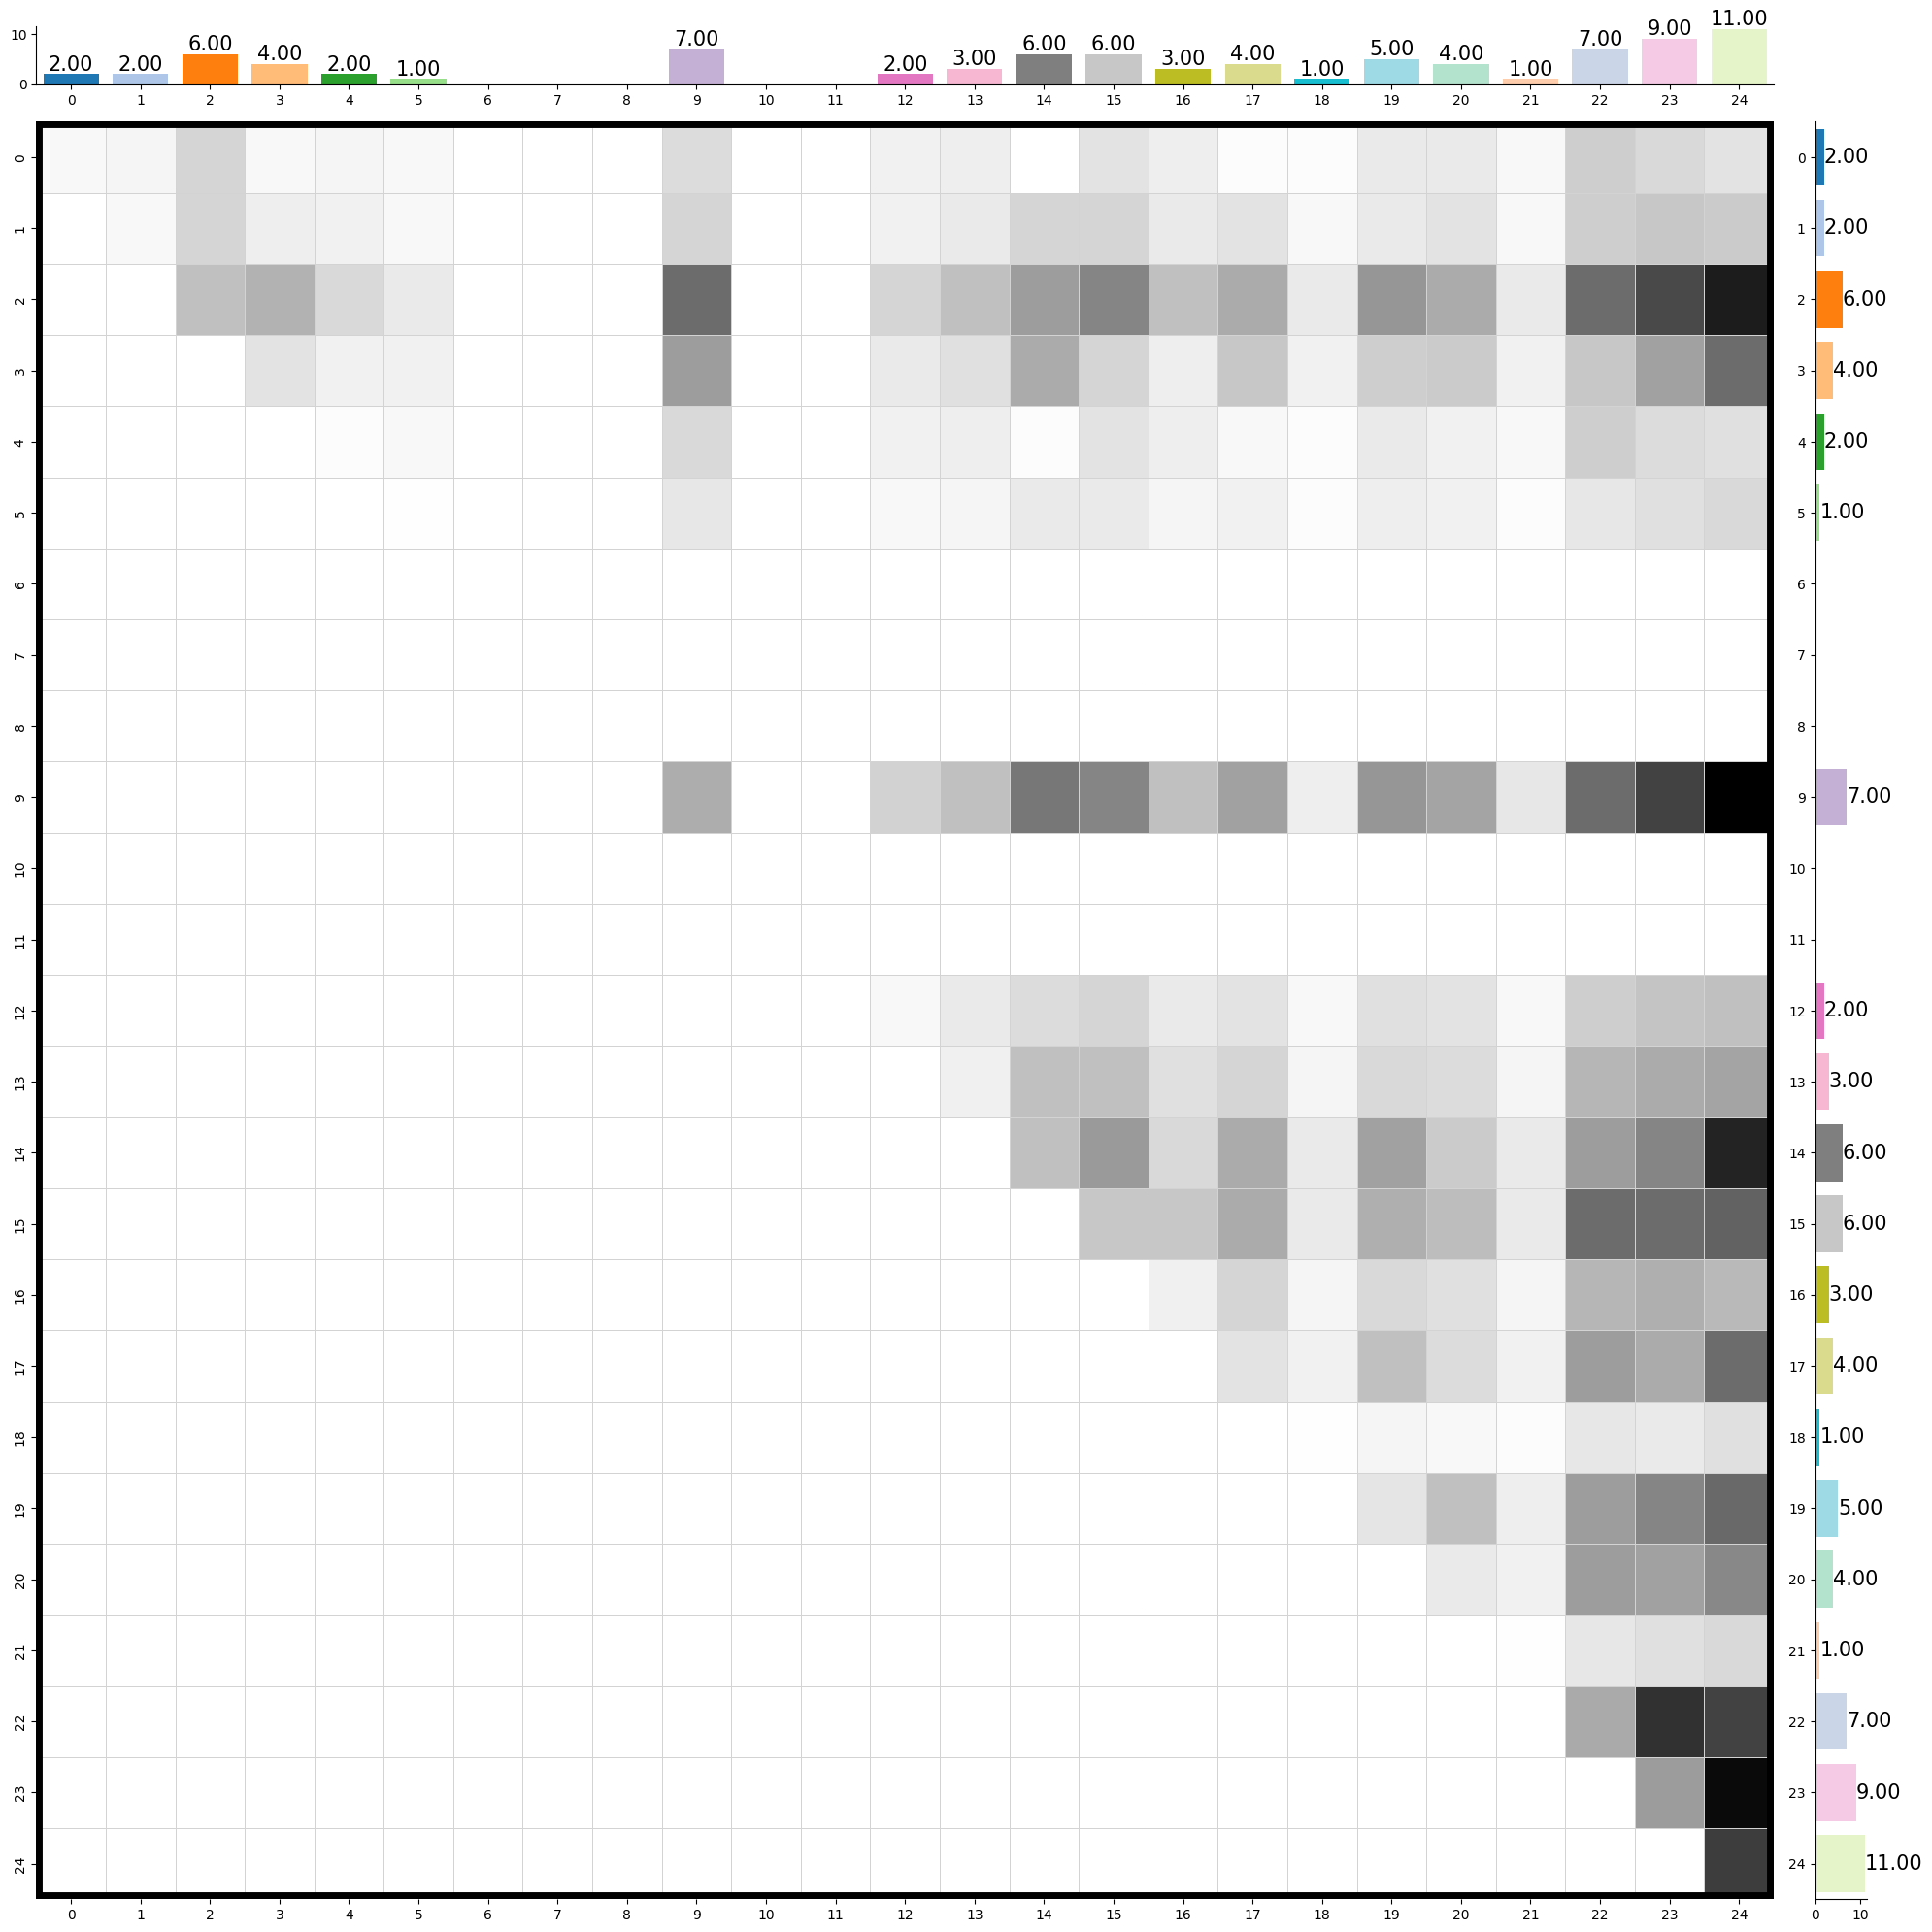

DEPRECATED: Please use 'center' method


visualizing sprite...
Structure exists: '../data/pdb5ud5.ent' 
[(0, '1'), (0, '2'), (23, '3'), (23, '4'), (20, '5'), (2, '6'), (15, '7'), (15, '8'), (2, '9'), (13, '10'), (22, '11'), (22, '12'), (12, '13'), (5, '14'), (9, '15'), (21, '16'), (9, '17'), (19, '18'), (23, '19'), (19, '20'), (19, '21'), (1, '22'), (9, '23'), (17, '24'), (24, '25'), (9, '26'), (24, '27'), (24, '28'), (9, '29'), (24, '30'), (24, '31'), (19, '32'), (23, '33'), (19, '34'), (24, '35'), (3, '36'), (3, '37'), (3, '38'), (24, '39'), (14, '40'), (14, '41'), (17, '42'), (14, '43'), (14, '44'), (24, '45'), (3, '46'), (24, '47'), (9, '48'), (24, '49'), (9, '50'), (20, '51'), (23, '52'), (4, '53'), (20, '54'), (15, '55'), (2, '56'), (2, '57'), (16, '58'), (2, '59'), (2, '60'), (22, '61'), (22, '62'), (12, '63'), (23, '64'), (1, '65'), (23, '66'), (24, '67'), (18, '68'), (17, '69'), (23, '70'), (14, '71'), (17, '72'), (23, '73'), (14, '74'), (20, '75'), (15, '76'), (15, '77'), (15, '78'), (13, '79'), (16, '80'), (16, '81

DEPRECATED: Please use 'center' method
DEPRECATED: Please use 'center' method


[(6.1655985644174995, '1'), (0.0, '2'), (6.736943043383559, '3'), (12.616135415116098, '4'), (4.828815886050206, '5'), (0.0, '6'), (22.61034477801255, '7'), (22.61034477801255, '8'), (0.0, '9'), (0.0, '10'), (22.95266063897843, '11'), (22.95266063897843, '12'), (16.09628211704028, '13'), (52.288497316597244, '14'), (16.15558805064281, '15'), (46.696989500259704, '16'), (16.15558805064281, '17'), (44.32294740395907, '18'), (62.22292640392948, '19'), (44.32294740395907, '20'), (44.32294740395907, '21'), (0.0, '22'), (16.15558805064281, '23'), (407.72935483070114, '24'), (48.2510962374845, '25'), (16.15558805064281, '26'), (48.2510962374845, '27'), (48.2510962374845, '28'), (16.15558805064281, '29'), (48.2510962374845, '30'), (48.2510962374845, '31'), (35.45460075569092, '32'), (30.253712530313717, '33'), (31.02982035024769, '34'), (38.4263583531123, '35'), (16.516300852351005, '36'), (16.516300852351005, '37'), (16.516300852351005, '38'), (48.2510962374845, '39'), (188.83785587196175, '4

In [80]:
G_test_dir = f"../data/{encoder}_{metal}_{cutoff}_test_graphs_2"
# G_id = filt[filt.value ==1].datum_id.sample(1).iloc[0][:-4]
# print(G_id)
G_id = "5ud5A" #"G-test_001" #"G-test_021"

kernel_map, sprite_viz, prospect_map, gt = create_visualizations(G_id, model_str, processor_cache_dir, model_cache_dir, G_test_dir, datatype="protein", gt_path=None)

In [81]:
sprite_viz

NGLWidget()

In [76]:
prospect_map

NGLWidget()

In [77]:
gt

NGLWidget()

In [ ]:
proc = utils.deserialize_model(os.path.join(processor_cache_dir, processor_name))
model = utils.deserialize_model(os.path.join(model_cache_dir, model_str))
model.visualize_motif_graph(labels=True) # sets color
color_assign = model.color_assignments

if datatype == "protein":
    G_path = G_dir + "/" + G_id + ".pkl"
elif datatype in ["text","image"]:
    G_path = G_dir + "/" + G_id 
G = utils.deserialize(G_path)
sprite = utils.construct_sprite(G, proc)
P = model.prospect(G)



In [ ]:
G_id = "2eg4A"
kernel_map, sprite_viz, prospect_map, gt = create_visualizations(G_id, model_str, processor_cache_dir, model_cache_dir, G_dir, datatype="protein")

In [12]:
from Bio.PDB import PDBParser
from Bio.PDB.Selection import unfold_entities
bp = PDBParser().get_structure('5ud5A', f'../data/pdb5ud5.ent')
for c in unfold_entities(bp, "C"):
    if c.id == "A":
        bp_chain = c
print(bp_chain)

<Chain id=A>


/Users/AWFDerry/anaconda3/envs/k2/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9320.
  warnings.warn(
/Users/AWFDerry/anaconda3/envs/k2/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9322.
  warnings.warn(
/Users/AWFDerry/anaconda3/envs/k2/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9330.
  warnings.warn(
/Users/AWFDerry/anaconda3/envs/k2/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9350.
  warnings.warn(


In [13]:
bp = utils.load_structure('5ud5A')

Structure exists: '../data/pdb5ud5.ent' 


/Users/AWFDerry/anaconda3/envs/k2/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9320.
  warnings.warn(
/Users/AWFDerry/anaconda3/envs/k2/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9322.
  warnings.warn(
/Users/AWFDerry/anaconda3/envs/k2/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9330.
  warnings.warn(
/Users/AWFDerry/anaconda3/envs/k2/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9350.
  warnings.warn(


In [56]:
import nglview
view = nglview.show_biopython(bp)

In [ ]:
save_image(sprite_viz, f'{G_id}_sprite')

In [ ]:
sprite_viz

In [ ]:
prospect_map